In [ ]:
# import os 
# import pandas as pd
# import bokeh
# from matplotlib import pyplot as plt
# import numpy as np
# #import bokeh
# #from holoviews import opts
# #import holoviews as hv
# #hv.extension('bokeh', logo=False)
# import seaborn as sns
# import plotly.express as px



 
# demultiplex_folder = Path(os.path.join(result_folder, experiment_folder, "demultiplex_60_reversed"))

# barcode_dicts = get_barcode_dict(demultiplex_folder)

In [181]:
import sys
sys.path.append("/home/emre/github_repo/MinION")
from minION import analyser
from minION import consensus
import importlib
from minION.util import IO_processor
importlib.reload(IO_processor)
importlib.reload(analyser)
importlib.reload(consensus)
from uncertainties import ufloat 
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns

In [182]:
folder_path = Path("/home/emre/minION_results/MinION_RBC_0902723_sup/demultiplex/barcode01/barcode08")
template_fasta = Path("/home/emre/github_repo/MinION/minION/refseq/hetcpiii.fasta")
#consensus.get_consensus(folder_path, template_fasta)

In [192]:
d_path = "/home/emre/minION_results/MinION_RBC_0902723_sup/Demultiplex_cpp_70_short"
#d_path = "/home/emre/minION_results/20230905_errorprone-3_test_sup/demultiplex"
#d_path = "/home/emre/tutorials/sequence_tut/data/Demultiplex"
summary = analyser.read_summary_file(d_path, summary_file="barcoding_summary.txt")


In [193]:
summary

,RBC,RBC_Score,FBC,FBC_Score
0,unclassified,34.6835,NaN,0.0000
1,RB02,100.0000,unclassified,38.5072
2,RB01,100.0000,NB61,85.6901
3,RB02,100.0000,NB27,100.0000
4,RB03,100.0000,unclassified,39.1194
...,...,...,...,...
559767,RB01,100.0000,NB77,100.0000
559768,RB03,100.0000,NB04,87.6280
559769,RB01,83.6717,NB56,100.0000
559770,RB01,100.0000,NB23,95.8719


In [194]:
import pandas as pd
ref_csv = pd.read_csv("/home/emre/minION_results/AminoAcids_Coupled_Max.csv")

In [ ]:
summary.groupby(["RBC","FBC"])["FBC"].value_counts().reset_index()

In [ ]:
template = analyser.get_template_sequence(template_fasta) # Reference sequence
template_aa = analyser.translate_sequence([template])

consensus = analyser.get_consensus_sequence(path_file, True)
quality = analyser.mean_quality_score(consensus["Quality-Score"][0])
consensus_aa = analyser.translate_sequence(consensus["Sequence"])

In [ ]:
aa_variants = analyser.call_variant(template_aa["Protein-Sequence"][0], consensus_aa["Protein-Sequence"][0], quality)


In [ ]:
#Concat a column from ref_csv to variant_df
variant_df[variant_df["Plate"] == 2]

In [ ]:
variant_df["Truth"] = ref_csv["VariantCombo"]

In [ ]:
#Remove truth column
tmp = pd.read_csv("/home/emre/minION_results/MinION_RBC_0902723_sup/demultiplex_cpp_70_variant_df_all.csv")
tmp["Truth"] = ref_csv["VariantCombo"]
new_variant_df = pd.merge(variant_df, tmp[["Plate","Well","Truth"]], on=["Plate","Well"], how="left")

In [ ]:
new_variant_df

In [ ]:
variant_df[variant_df["Plate"] == 2].head(20)

In [ ]:
import pandas as pd
##new_var_df = pd.read_csv("/home/emre/minION_results/MinION_RBC_0902723_sup/demultiplex_cpp_70_variant_df_all.csv")

new_variant_df.to_csv("/home/emre/minION_results/MinION_RBC_0902723_sup/demultiplex_cpp_70_variant_df_short_rev_top10p.csv")

In [ ]:
new_var_df["Acc (1 or 0)"].sum()/288

In [ ]:
acc = new_var_df.groupby("Plate")["Acc (1 or 0)"].sum()/96

In [ ]:
# Barplot for accuracy
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=acc.index, y=acc.values)
ax.set(xlabel='Plate', ylabel='Accuracy')
plt.title("Smith-Waterman Demultiplexing & Medaka Consensus Accuracy")
plt.savefig("/home/emre/minION_results/MinION_RBC_0902723_sup/accuracy.png")
plt.show()


In [12]:
import subprocess
import pysam

def call_and_filter_vcf(input_path, reference, allele_frequency):
    # Define the output VCF file path
    
    prompt_pileup = f"bcftools mpileup -d 4000 -Ou -f {reference}  {input_path}/alignment.bam > {input_path}/pileup.bcf"

    prompt_call = f"bcftools call -mv -Ob -o {input_path}/raw_variants.bcf {input_path}/pileup.bcf"

    prompt_view = f"bcftools view -i 'INFO/AF>{allele_frequency}' -Ob -o {input_path}/filtered_variants.vcf {input_path}/raw_variants.bcf"


    subprocess.run(prompt_pileup, shell=True)

    subprocess.run(prompt_call, shell=True)

    subprocess.run(prompt_view, shell=True)

    print(f"Variant calling and filtering completed. Output saved to {input_path}/raw_variants_python.bcf")


def extract_positions_from_vcf(vcf_file):
    positions = []

    # Open the VCF file using pysam 
    vcf = pysam.VariantFile(vcf_file)

    for record in vcf:
        # Get the position of the variant
        position = record.pos
        positions.append(position)
    
    # Close the VCF file
    vcf.close()

    return positions

def extract_mutations_from_vcf(vcf_file):
    mutations = []

    # Open the VCF file using pysam
    vcf = pysam.VariantFile(vcf_file)

    for record in vcf:
        # Get the reference allele
        ref_allele = record.ref
        # Get the alternate alleles (variants)
        alt_alleles = record.alts

        # Iterate through alternate alleles
        for alt_allele in alt_alleles:
            # Get the position of the variant
            position = record.pos
            # Format the mutation as "REFPOSALT"
            mutation = f"{ref_allele}{position}{alt_allele}"
            mutations.append(mutation)

    # Close the VCF file
    vcf.close()

    # Join mutations with "_"
    formatted_mutations = "_".join(mutations)

    return formatted_mutations


In [227]:
barcodes = IO_processor.get_barcode_dict(Path("/home/emre/minION_results/MinION_RBC_0902723_sup/Demultiplex_cpp_70_short"))
#path_to_bam = "/home/emre/minION_results/MinION_RBC_0902723_sup/Demultiplex_cpp_70_short/RB03/NB08/consensus"
path_to_bam = "/home/emre/minION_results/Flongle_3RBC_sup/Demultiplex_cpp_70/RB01/NB53"
template_fasta = "/home/emre/github_repo/MinION/minION/refseq/hetcpiii.fasta"
output_vcf = f"{path_to_bam}/raw_variants.vcf"
#consensus.get_consensus(Path(path_to_bam), Path(template_fasta))
call_and_filter_vcf(path_to_bam, template_fasta, 0.4)


Variant calling and filtering completed. Output saved to /home/emre/minION_results/Flongle_3RBC_sup/Demultiplex_cpp_70/RB01/NB53/raw_variants_python.bcf


[E::hts_open_format] Failed to open file "/home/emre/minION_results/Flongle_3RBC_sup/Demultiplex_cpp_70/RB01/NB53/alignment.bam" : No such file or directory
[mpileup] failed to open /home/emre/minION_results/Flongle_3RBC_sup/Demultiplex_cpp_70/RB01/NB53/alignment.bam: No such file or directory
Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
Failed to read from /home/emre/minION_results/Flongle_3RBC_sup/Demultiplex_cpp_70/RB01/NB53/pileup.bcf: unknown file type
[E::hts_open_format] Failed to open file "/home/emre/minION_results/Flongle_3RBC_sup/Demultiplex_cpp_70/RB01/NB53/raw_variants.bcf" : No such file or directory
Failed to read from /home/emre/minION_results/Flongle_3RBC_sup/Demultiplex_cpp_70/RB01/NB53/raw_variants.bcf: No such file or directory


In [228]:
extract_mutations_from_vcf(f'{path_to_bam}/filtered_variants.vcf')

[E::hts_open_format] Failed to open file "/home/emre/minION_results/Flongle_3RBC_sup/Demultiplex_cpp_70/RB01/NB53/filtered_variants.vcf" : No such file or directory


FileNotFoundError: [Errno 2] could not open variant file `b'/home/emre/minION_results/Flongle_3RBC_sup/Demultiplex_cpp_70/RB01/NB53/filtered_variants.vcf'`: No such file or directory

In [229]:
nb_positions = extract_positions_from_vcf(f'{path_to_bam}/filtered_variants.vcf')

[E::hts_open_format] Failed to open file "/home/emre/minION_results/Flongle_3RBC_sup/Demultiplex_cpp_70/RB01/NB53/filtered_variants.vcf" : No such file or directory


FileNotFoundError: [Errno 2] could not open variant file `b'/home/emre/minION_results/Flongle_3RBC_sup/Demultiplex_cpp_70/RB01/NB53/filtered_variants.vcf'`: No such file or directory

In [230]:
nb_positions

[220]

In [231]:
import pysam

bam_file = f'{path_to_bam}/consensus/alignment.bam'

In [232]:
from collections import Counter
import pysam

def get_base_counts_at_position(bam_file, chrom, position):
    """
    Extract unique bases and gaps (deletions) and their counts from a BAM file 
    at a specific position using pileup.
    
    Args:
    - bam_file (str): path to the BAM file.
    - chrom (str): chromosome or contig name.
    - position (int): 1-based position to extract bases from.

    Returns:
    - dict: unique bases and gaps with their counts at the specified position.
    """
    
    bases = []

    # Open the BAM file using pysam
    with pysam.AlignmentFile(bam_file, 'rb') as bam:
        for pileup_column in bam.pileup(chrom, position - 1, position, 
                                        min_base_quality=0, 
                                        min_mapping_quality=0, 
                                        truncate=True):
            if pileup_column.pos == position - 1:  # Adjust for 0-based
                for pileup_read in pileup_column.pileups:
                    if pileup_read.is_del:
                        bases.append("-")  # Using '-' to represent a deletion (gap)
                    elif not pileup_read.is_refskip:
                        bases.append(pileup_read.alignment.query_sequence[pileup_read.query_position])

    # Count the unique bases and gaps
    base_counts = Counter(bases)

    return base_counts

In [233]:
reference = "HetCPIII"  # For example
position_to_check = 1  # 0-based position
bases_at_position = get_base_counts_at_position(bam_file, reference, position_to_check)
bases_at_position

Counter({'A': 38})

In [234]:
def generate_heatmap_data(bam_file, chrom, start, end):
    data = []
    all_bases = set(['A', 'T', 'C', 'G', '-'])
    for position in range(start, end + 1):
        base_counts = get_base_counts_at_position(bam_file, chrom, position)
        col = [base_counts.get(base, 0) for base in all_bases]
        data.append(col)
    df = pd.DataFrame(data, index=range(start, end + 1), columns=list(all_bases))
    # Order as in all_bases
    df = df[['A', 'T', 'C', 'G', '-']]
    return df

def generate_heatmap_data_specific(bam_file, chrom, positions):
    data = []
    all_bases = set(['A', 'T', 'C', 'G', '-'])
    for position in positions:
        base_counts = get_base_counts_at_position(bam_file, chrom, position)
        col = [base_counts.get(base, 0) for base in all_bases]
        data.append(col)
    df = pd.DataFrame(data, index=positions, columns=list(all_bases))
    # Order as in all_bases
    df = df[['A', 'T', 'C', 'G', '-']]
    return df



In [235]:
# from matplotlib import pyplot as plt
# import seaborn as sns
#heatmap_data = generate_heatmap_data(bam_file, reference, 1, 100)
heatmap_data = generate_heatmap_data_specific(bam_file, reference, [219,220,221])

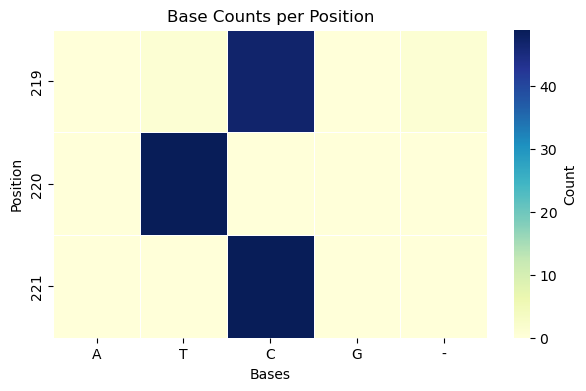

In [236]:

template = analyser.get_template_sequence(template_fasta)

# Plotting
plt.figure(figsize=(7, 4))
sns.heatmap(heatmap_data, 
            annot=False, 
            cmap='YlGnBu', 
            cbar_kws={'label': 'Count'}, 
            linewidths=0.5, 
            linecolor='white')
plt.title("Base Counts per Position")
plt.xlabel("Bases")
plt.ylabel("Position")
plt.show()

In [237]:
from collections import Counter

def get_highest_non_ref_base_freq(bam_file, chrom, positions, reference_sequence):
    base_frequencies = {position: Counter() for position in positions}
    
    with pysam.AlignmentFile(bam_file, 'rb') as bam:
        for pileup_column in bam.pileup(chrom, min(positions) - 1, max(positions),
                                        min_base_quality=0, 
                                        min_mapping_quality=0, 
                                        truncate=True):
            if pileup_column.pos + 1 in positions:
                bases = []
                for pileup_read in pileup_column.pileups:
                    if not pileup_read.is_del and not pileup_read.is_refskip:
                        base = pileup_read.alignment.query_sequence[pileup_read.query_position].upper()
                        bases.append(base)
                    else:
                        bases.append("-")
                base_frequencies[pileup_column.pos + 1].update(bases)

    # Calculate highest non-reference base frequency
    highest_non_ref_base_freq = {}
    for position in positions:
        counts = base_frequencies[position]
        ref_base = reference_sequence[position - 1].upper()  # adjust 1-based to 0-based
        
        total_bases = sum(counts.values())
        if total_bases > 0:
            non_ref_bases = {base: count for base, count in counts.items() if base != ref_base}
            if non_ref_bases:
                max_base = max(non_ref_bases, key=non_ref_bases.get)
                max_freq = non_ref_bases[max_base] / total_bases
                highest_non_ref_base_freq[position] = (max_base, max_freq)
            else:
                highest_non_ref_base_freq[position] = (None, 0)
        else:
            highest_non_ref_base_freq[position] = (None, 0)

    return highest_non_ref_base_freq

ref_seq = analyser.get_template_sequence(template_fasta)
freq_dist = pd.DataFrame(get_highest_non_ref_base_freq(bam_file, reference, range(1,612), ref_seq)).T

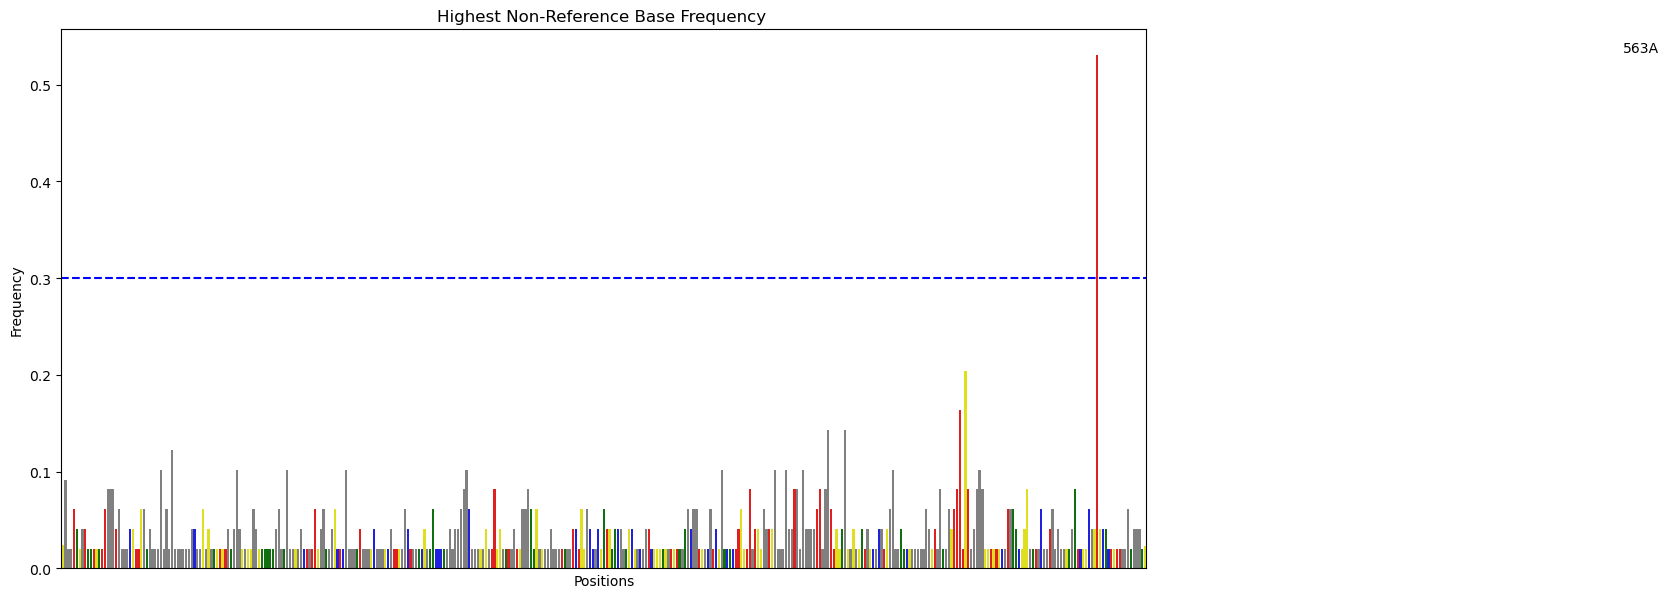

In [238]:
colors_for_bases = {"-" : "grey", "A" : "red", "T" : "blue", "C" : "green", "G" : "yellow"}

freq_dist = freq_dist.rename(columns={0:"Base", 1:"Frequency"})

freq_dist = freq_dist.dropna()

freq_dist["Color"] = freq_dist["Base"].map(colors_for_bases)


# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(x=freq_dist.index, y=freq_dist["Frequency"], palette=freq_dist["Color"])
plt.title("Highest Non-Reference Base Frequency ")
# Hide x-axis ticks
plt.xticks([])
plt.xlabel("Positions")
plt.ylabel("Frequency")
#Add horizontal line at 0.1
plt.axhline(y=0.3, color='b', linestyle='--')
# Add text to position > 0.1
for index, row in freq_dist.iterrows():
    if row["Frequency"] > 0.3:
        plt.text(index, row["Frequency"], f"{index}{row['Base']}", color='black', ha="center", va='bottom')

#plt.savefig("/home/emre/minION_results/MinION_RBC_0902723_sup/variant_freq_RB02_NB10.png")


In [197]:
freq_dist

,Base,Frequency,Color


Contingency Table for pair (112, 203)
        B  Not B
A       3      1
Not A  67      9
P-value: 0.4202664424183412
Contingency Table for pair (112, 215)
        B  Not B
A       4      1
Not A  64      9
P-value: 0.5062250220144958
Contingency Table for pair (203, 215)
       B  Not B
A      1      4
Not A  3     70
P-value: 0.23695252116304746


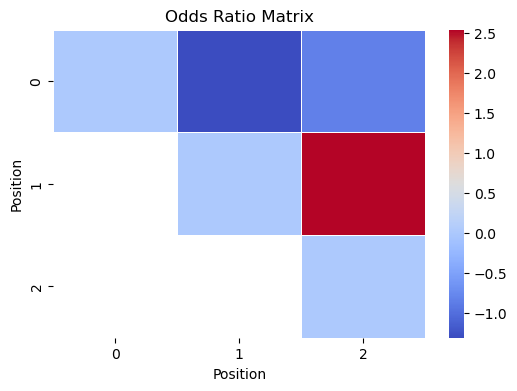

In [113]:
import pysam
import pandas as pd
from itertools import combinations
from scipy import stats
from scipy.stats import chi2_contingency

def get_most_common_base(position, heatmap_data, ref_base):
    non_ref_data = heatmap_data.loc[position].drop(ref_base)
    return non_ref_data.idxmax(), non_ref_data.max()

def get_bases_from_pileup(bam_file, chrom, positions):
    bases_dict = {position: [] for position in positions}
    read_names = []
    
    with pysam.AlignmentFile(bam_file, 'rb') as bam:
        for pileup_column in bam.pileup(chrom, min(positions) - 1, max(positions) + 1,
                                        min_base_quality=0, 
                                        min_mapping_quality=0, 
                                        truncate=True):
            if pileup_column.pos + 1 in positions:
                for pileup_read in pileup_column.pileups:
                    if not pileup_read.is_del and not pileup_read.is_refskip:
                        base = pileup_read.alignment.query_sequence[pileup_read.query_position]
                        read_name = pileup_read.alignment.query_name
                        bases_dict[pileup_column.pos + 1].append(base)
                        read_names.append(read_name)
    # Create a dataframe where each row is a read and each column is a position
    df = pd.DataFrame(index=read_names, columns=positions)
    
    # Fill the dataframe with nucleotide bases
    for pos, bases in bases_dict.items():
        for read_name, base in zip(read_names, bases):
            df.at[read_name, pos] = base
    
    # Replace NaN values with "-"
    df = df.fillna("-")
    
    
    return df
            

# Calculate for each pair chi-squared test
nb_positions = extract_positions_from_vcf(f'{path_to_bam}/filtered_variants.vcf')
comb = list(combinations(nb_positions, 2))
heatmap_data = generate_heatmap_data_specific(bam_file, reference, nb_positions)

# Initialize a matrix with zeros for storing the -log10(p-values)
pval_matrix = np.zeros((len(nb_positions), len(nb_positions)))
odds_ratio_matrix = np.zeros((len(nb_positions), len(nb_positions)))


for pair in comb:
    
    max_nucleotide_pair1, _ = get_most_common_base(pair[0], heatmap_data, template[pair[0] - 1])
    max_nucleotide_pair2, _ = get_most_common_base(pair[1], heatmap_data, template[pair[1] - 1])

    bases_df = get_bases_from_pileup(bam_file, "HetCPIII", pair)

    A_and_B = len(bases_df[(bases_df[pair[0]] == max_nucleotide_pair1) & (bases_df[pair[1]] == max_nucleotide_pair2)])
    A_wo_B = len(bases_df[(bases_df[pair[0]] == max_nucleotide_pair1) & (bases_df[pair[1]] != max_nucleotide_pair2)])
    B_wo_A = len(bases_df[(bases_df[pair[0]] != max_nucleotide_pair1) & (bases_df[pair[1]] == max_nucleotide_pair2)])
    wo_A_and_B = len(bases_df[(bases_df[pair[0]] != max_nucleotide_pair1) & (bases_df[pair[1]] != max_nucleotide_pair2)])



    contingency_table = pd.DataFrame({
        'B': [A_and_B, A_wo_B],
        'Not B': [B_wo_A, wo_A_and_B]
    }, index=['A', 'Not A'])

    # Laplaci correction
    contingency_table += 1

    #chi2, p_value, _, _ = chi2_contingency(contingency_table)

    # Fisher's exact test
    oddsratio, p_value = stats.fisher_exact(contingency_table)
    oddsratio = np.log2(oddsratio)
    odds_ratio_matrix[nb_positions.index(pair[0])][nb_positions.index(pair[1])] = oddsratio


    print("Contingency Table for pair", pair)
    print(contingency_table)
    print("P-value:", p_value)

    neg_log_p_value = -np.log10(p_value)

    # Store the values in the matrix
    pval_matrix[nb_positions.index(pair[0])][nb_positions.index(pair[1])] = neg_log_p_value



# Masking the lower triangle of the matrix
mask = np.tri(pval_matrix.shape[0], k=-1)

# Plotting the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(odds_ratio_matrix, cmap='coolwarm', mask=mask, linewidths=0.5, linecolor='white')
sns.xticklabels = nb_positions
sns.yticklabels = nb_positions
#Label the axes
plt.xlabel('Position')
plt.ylabel('Position')
plt.title("Odds Ratio Matrix")
plt.show()



In [133]:
freq_dist[freq_dist["Frequency"] > 0.3]

,Base,Frequency,Color
112,A,0.894737,red
204,-,0.868421,grey
216,-,0.842105,grey


In [139]:
freq_dist.iloc[80:120]

,Base,Frequency,Color
182,A,0.026316,red
183,G,0.026316,yellow
184,C,0.026316,green
185,C,0.078947,green
186,-,0.052632,grey
187,-,0.052632,grey
188,T,0.052632,blue
189,A,0.078947,red
194,A,0.026316,red
195,-,0.026316,grey
